# 0. Setup Environement

In [1]:
from google.colab import drive

drive.mount("/content/drive")

%cd /content/drive/MyDrive/nyu-stuff/2023-fall/DS-UA\ 301\ Advanced\ DS/final_project

Mounted at /content/drive
/content/drive/MyDrive/nyu-stuff/2023-fall/DS-UA 301 Advanced DS/final_project


In [2]:
%%capture
%pip install -r requirements.txt
%pip install wandb -Uq
import pandas
import numpy
import json5
import functools
import json
from matplotlib import pyplot
from typing import Optional, Any, Coroutine, Union, Dict, List
import nltk
from nltk.corpus import stopwords
import string
import contractions
import torch
import wandb
import sklearn
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

nltk.download("averaged_perceptron_tagger")
nltk.download("universal_tagset")
nltk.download("stopwords")
nltk.download("punkt")

In [3]:
def get_best_torch_device():
    if torch.cuda.is_available():  # CUDA
        return "cuda"
    elif torch.backends.mps.is_available():  # Apple Silicon / GPU
        return "mps"
    else:  # Fallback to CPU
        return "cpu"

# 1. Data Loading & Configure Hyperparameters

In [4]:
# Configure hyperparameters (+ random state)
random_state = 13117
h_iter = 128
h_batch_size = 4096
h_test_size = 0.1
h_validation_size = 0.1
h_layers = 4
h_learning_rate = 0.005

device = get_best_torch_device()
print(f"Currently using {device.upper()} for training!")

Currently using CUDA for training!


In [5]:
label_data = pandas.read_csv("data/balanced_with_labels.csv")

# Shuffle data
label_data = label_data.sample(frac=1, random_state=random_state)


# Base on results from eye-balling the dataset,
# people seem to have a hard time giving intermediate (2 and 4) ratings,
# lets flat them.
def get_flat_value(input_val):
    if input_val < 2:
        return 1
    elif input_val < 4:
        return 3
    else:
        return 5


label_data["rating"] = [get_flat_value(x) for x in label_data["rating"]]
display(label_data.head(10))

,review_text,rating,length,good,decent,mediocre,bad,horrible
35243,The case is a very tight fit and the back remi...,5,123,0.360874,0.225490,0.075706,0.316110,0.021820
29126,"Works fine, but I had to put a few locking sq...",3,137,0.262977,0.723278,0.008984,0.003572,0.001188
28232,I purchased this item along with DKnight and A...,3,923,0.385126,0.376884,0.068360,0.159016,0.010614
22265,Corner Tabs feels like it is going to break/sn...,3,209,0.711987,0.235765,0.024387,0.023371,0.004490
6891,"Did not work at all, went to walmart and bough...",1,422,0.009885,0.010234,0.113022,0.600792,0.266068
2317,Purchased this case for the Lumia 1020 because...,1,611,0.024491,0.013958,0.337273,0.433872,0.190405
29361,"it is just ok, i guess, it is at my desk, i ch...",3,105,0.031582,0.353640,0.612850,0.001231,0.000697
20274,Works as advertized but only support one phone...,3,624,0.083988,0.436971,0.393090,0.082832,0.003119
43840,like the title says.I love this case.My note 1...,5,100,0.632552,0.364548,0.001383,0.000879,0.000638
4412,"I have to revise my opinion of this earpiece, ...",1,322,0.053848,0.008828,0.029792,0.574338,0.333193


In [6]:
train_set, tmp_set = train_test_split(
    label_data, test_size=h_test_size + h_validation_size, random_state=random_state
)
test_set, validation_set = train_test_split(
    tmp_set,
    test_size=h_validation_size / (h_validation_size + h_test_size),
    random_state=random_state,
)
# train_set = label_data.sample(frac=1 - h_test_size, random_state=random_state)
# test_set = label_data.sample(frac=h_test_size, random_state=random_state)

In [7]:
class FairDataset(torch.utils.data.Dataset):
    def __init__(self, df_input):
        df_x = df_input[
            [
                c
                for c in df_input.columns
                if c not in ["review_text", "rating", "length"]
            ]
        ]
        df_y = df_input["rating"]
        self.features = torch.tensor(df_x.values, dtype=torch.float32).to(device)
        self.labels = torch.tensor(df_y.values, dtype=torch.float32).to(device)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [8]:
ds_train = FairDataset(train_set)
ds_test = FairDataset(test_set)
ds_validation = FairDataset(validation_set)

In [9]:
print("# of samples in train set:", len(ds_train))
print("# of samples in test set:", len(ds_test))
print("# of samples in validation set:", len(ds_validation))

# of samples in train set: 40000
# of samples in test set: 5000
# of samples in validation set: 5000


# 2. Define and Train Model

In [10]:
def spawn_layers(
    n_layers,
    input_size,
    output_size,
    is_batch_norm=True,
    activation_func=nn.ReLU,
    output_func=nn.LogSoftmax,
):
    layers = []
    prev_hidden = input_size

    for i in range(n_layers):
        hidden_size = int((prev_hidden + output_size) / 2)

        layers += [
            nn.Linear(in_features=prev_hidden, out_features=hidden_size),
            nn.BatchNorm1d(hidden_size) if is_batch_norm else nn.Identity(),
            activation_func(),
        ]

        prev_hidden = hidden_size

    return layers + [output_func(dim=1)]

In [11]:
sample_input, sample_output = ds_train[0]

input_size = len(sample_input)
output_size = len(str(sample_output))

In [12]:
columns = ["epoch", "train_loss", "val_loss", "val_accuracy"]


loader_test = DataLoader(ds_test, batch_size=h_batch_size, shuffle=False)
loader_validation = DataLoader(ds_validation, batch_size=h_batch_size, shuffle=False)


def train_node(params):
    rows = []
    batch_size = params["batch_size"]
    n_layers = params["n_layers"]
    learning_rate = params["learning_rate"]
    n_epochs = params["n_epochs"]
    is_batch_norm = params["is_batch_norm"]

    optimizer_func = (
        torch.optim.Adam if params["optimizer"] == "adam" else torch.optim.SGD
    )
    activation_func = (
        nn.LeakyReLU if params["activation_func"] == "leaky_relu" else nn.ReLU
    )

    loader_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True)

    # Intialize Model
    model = nn.Sequential(
        *spawn_layers(
            n_layers,
            input_size,
            output_size,
            activation_func=activation_func,
            is_batch_norm=is_batch_norm,
        )
    ).to(device)

    # Initalize Optimizer (Adam in this case)
    optimizer = optimizer_func(model.parameters(), lr=learning_rate)

    # Initialize Loss Function
    criterion = nn.CrossEntropyLoss()

    best_val_loss = -1
    best_chkpt = None
    best_accuracy = -1

    for epoch in range(n_epochs):
        model.train()  # Set the model to training mode

        loss = None
        val_loss = None
        for inputs, labels in loader_train:
            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)

            # Compute the loss
            loss = criterion(outputs, labels.long())

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

        # Validation after each epoch
        model.eval()
        correct = 0
        total = 0

        # Get validation loss and accuracy
        with torch.no_grad():
            for inputs, labels in loader_validation:
                outputs = model(inputs)
                val_loss = criterion(outputs, labels.long())

                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_accuracy = correct / total
        val_loss_num = val_loss.item()

        # Save the model with minimum val loss
        if best_val_loss == -1 or val_loss_num < best_val_loss:
            best_val_loss = val_loss_num
            best_accuracy = val_accuracy
            best_chkpt = {
                "params": params,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "epoch": epoch,
                "loss": loss,
                "val_loss": val_loss,
                "val_accuracy": val_accuracy,
            }

        # Print telemetry data
        print(
            f"\rEpoch [{epoch+1}/{n_epochs}] train_loss: {loss.item():.4f},"
            f"val_loss: {val_loss.item():.4f},"
            f"val_acc: {val_accuracy}",
            end="",
        )

        rows.append([epoch, loss.item(), val_loss.item(), val_accuracy])

    df_results = pandas.DataFrame(rows, columns=columns)
    print("")

    return df_results, best_val_loss, best_accuracy, best_chkpt, model

In [13]:
h_optimizer = "adam"

df_results, best_val_loss, best_accuracy, best_chkpt, model = train_node(
    {
        "batch_size": h_batch_size,
        "n_layers": h_layers,
        "learning_rate": h_learning_rate,
        "n_epochs": h_iter,
        "optimizer": h_optimizer,
        "is_batch_norm": True,
        "activation_func": "leaky_relu",
    }
)

Epoch [128/128] train_loss: 0.6997,val_loss: 0.6833,val_acc: 0.7218


Text(0.5, 1.0, 'Losses vs Number of Epochs')

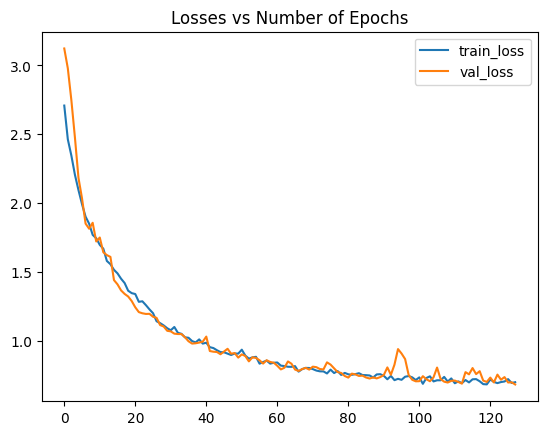

In [14]:
pyplot.plot(df_results["train_loss"], label="train_loss")
pyplot.plot(df_results["val_loss"], label="val_loss")
pyplot.legend()
pyplot.title(f"Losses vs Number of Epochs")

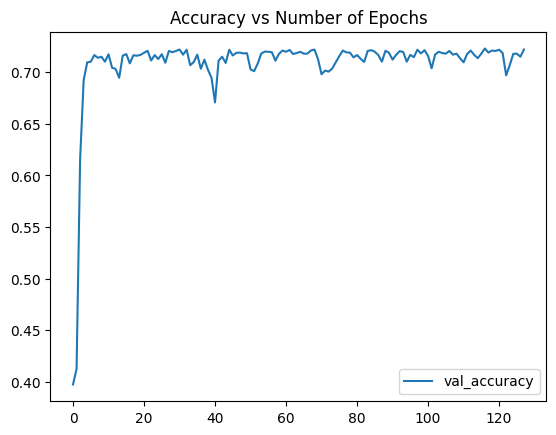

In [15]:
pyplot.plot(df_results["val_accuracy"], label="val_accuracy")
pyplot.title(f"Accuracy vs Number of Epochs")
pyplot.legend()

# 3. Hyperparameter Tuning

In [16]:
params = {
    "learning_rate": [0.001, 0.005, 0.01],
    "optimizer": ["adam", "sgd"],
    "n_layers": [3, 4, 5],
    "is_batch_norm": [True],
    "activation_func": ["relu", "leaky_relu"],
    "n_epochs": [128],
    "batch_size": [8192,16384],
}

sweep_config = {
    "method": "random",
    "metric": {"name": "loss", "goal": "minimize"},
}

sweep_config["parameters"] = {k: {"values": v} for k, v in params.items()}

In [17]:
wandb.login()

loss_mp = {}


def train_wandb(config=None):
    with wandb.init(config=config):
        config = wandb.config
        result_df, val_loss, val_acc, chkpt, model = train_node(config)

        # Get test accuracy
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in loader_test:
                outputs = model(inputs)

                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        test_acc = correct / total

        loss_mp[val_loss] = {
            "config": config,
            "result_df": result_df,
            "val_loss": val_loss,
            "val_acc": val_acc,
            "test_acc": test_acc,
            "chkpt": chkpt,
        }

        wandb.log({"loss": val_loss})

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
sweep_id = wandb.sweep(sweep_config, project="FAIR_sweep_final")
wandb.agent(sweep_id, train_wandb, count=32)

Create sweep with ID: h6nue0tl
Sweep URL: https://wandb.ai/lbypatrick/FAIR_sweep_final/sweeps/h6nue0tl


wandb: Agent Starting Run: ccflrggj with config:
wandb: 	activation_func: leaky_relu
wandb: 	batch_size: 16384
wandb: 	is_batch_norm: True
wandb: 	learning_rate: 0.005
wandb: 	n_epochs: 128
wandb: 	n_layers: 4
wandb: 	optimizer: adam
wandb: Currently logged in as: lbypatrick. Use `wandb login --relogin` to force relogin


Epoch [128/128] train_loss: 0.9939,val_loss: 0.9566,val_acc: 0.7184


loss,▁
loss,0.95656


wandb: Agent Starting Run: q731nyco with config:
wandb: 	activation_func: leaky_relu
wandb: 	batch_size: 16384
wandb: 	is_batch_norm: True
wandb: 	learning_rate: 0.001
wandb: 	n_epochs: 128
wandb: 	n_layers: 3
wandb: 	optimizer: adam


Epoch [128/128] train_loss: 1.8521,val_loss: 1.7737,val_acc: 0.7142


loss,▁
loss,1.77373


wandb: Agent Starting Run: q72m3z7c with config:
wandb: 	activation_func: leaky_relu
wandb: 	batch_size: 16384
wandb: 	is_batch_norm: True
wandb: 	learning_rate: 0.005
wandb: 	n_epochs: 128
wandb: 	n_layers: 5
wandb: 	optimizer: adam


Epoch [127/128] train_loss: 0.9971,val_loss: 0.9960,val_acc: 0.7178

In [ ]:
# for i, chkpt in enumerate(chkpts):
#   torch.save(chkpt, f"checkpoints/chkpt_{i}.pt")
torch.save(loss_mp, "data/sweep_result_loss_mp_fast_final.pickle")